Dependecies

In [1]:
import pandas as pd
import numpy as np
import os
# add global to sys
import sys
sys.path.insert(0, 'C:/Users/Lukasz/Documents/python/global_input')


Load FileExtractor class for loading and aggregating data from file

In [3]:
from packages.FileHandler import FileExtractor
path = 'C:/Users/Lukasz/Documents/python/global_input/data/aggregated'
prefix = "BTCUSDT"
timeframes = ["5T"]
start_date = "2015-01-01 00:00:00"
data = FileExtractor(path, prefix, timeframes, start_date)
df = data.data_dict[timeframes[0]]

add Features to DataFrame with custom Function and TAlib package
than add lags = 10 to open, high, low, close and volume

In [9]:
from packages.addFeatures import add_features, add_lags
data = add_features(df)
# lag features
lags = 10
data, cols = add_lags(data, lags)

Split and normalize data for train and test, normalize using just train std

In [10]:
# split data into train/test sets
split = int(len(data) * 0.67)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

# normalize data
mu, std = train.mean(), train.std()
train_ = (train - mu) / std # normalized train data (using train moments)
test_ = (test - mu) / std

# Train Support Vector Classifier Model
Predict direction

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(C=1)

model = clf.fit(train_[cols], train['direction'])
y_pred = model.predict(test_[cols])
accuracy_score(test['direction'], y_pred)

NameError: name 'train_' is not defined

In [11]:
# test['signals'] = np.where(y_pred == 1, 1, -1)
# test['model'] = test['signals'] * test['returns']
# test[['model', 'returns']].cumsum().apply(np.exp).plot()
# test[['model', 'returns']].sum().apply(np.exp) -1

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=int(len(data.columns) * 0.2))
ftrs_sel = selector.fit(train_[cols], train['direction']).get_support(indices=True)
fsel = train_[cols].columns[ftrs_sel].tolist()

model = clf.fit(train_[fsel], train['direction'])
y_pred = model.predict(test_[fsel])
accuracy_score(test['direction'], y_pred)

# backtest
test['signals'] = np.where(y_pred == 1, 1, -1)
test['model'] = test['signals'] * test['returns']
test[['model', 'returns']].cumsum().apply(np.exp).plot()
test[['model', 'returns']].sum().apply(np.exp) -1

In [11]:
accuracy_score(test['direction'], y_pred)

0.5573429482734711

For 1H Timeframe results: Accuracy 0.548 and with KBest 0.5573429482734711

# Backtest with real prices

In [17]:
backtest = df["2018-05-09 03:00:00":].copy()
backtest["next_close"] = backtest.close.shift(-1)
backtest["signals"] = test['signals']
backtest = backtest.reset_index()

capital = 100

for i in range(len(backtest)-1):
    position_size = capital / backtest.loc[i,"close"]
    if backtest.loc[i,"signals"] > 0:
        position_return =  backtest.loc[i,"next_close"] - backtest.loc[i,"close"]
    elif backtest.loc[i,"signals"] < 0:
        position_return =  backtest.loc[i,"close"] - backtest.loc[i,"next_close"]
    reward = position_size * position_return
    capital += reward
print(capital)




58.828134205335324


# Train XGBoost Model
For faster computation we will start with "1H" Timeframe
1. without KBest Features
2. with 20% best feature Columns


In [4]:
from packages.FileHandler import FileExtractor
timeframes = ["1H"]
data = FileExtractor(path, prefix, timeframes, start_date)
df = data.data_dict[timeframes[0]]

In [6]:
from packages.addFeatures import add_features, add_lags
# add lags
data = add_features(df)
# lag features
lags = 10
data, cols = add_lags(data, lags)

In [8]:
split = int(len(data) * 0.67)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

# normalize data
mu, std = train.mean(), train.std()
train_ = (train - mu) / std # normalized train data (using train moments)
test_ = (test - mu) / std

In [12]:
import xgboost as xgb
from sklearn.metrics import accuracy_score


xgb_cl = xgb.XGBClassifier()
model = xgb_cl.fit(train_[cols], train['direction'])
y_pred = model.predict(test_[cols])
accuracy_score(test['direction'], y_pred)

0.5378588267924005

plot return

model      14.931550
returns    -0.207049
dtype: float64

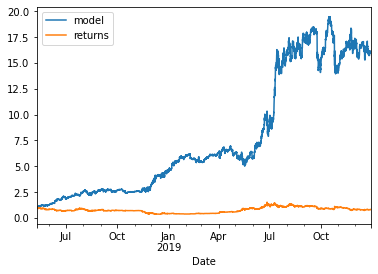

In [13]:
test['signals'] = np.where(y_pred == 1, 1, -1)
test['model'] = test['signals'] * test['returns']
test[['model', 'returns']].cumsum().apply(np.exp).plot()
test[['model', 'returns']].sum().apply(np.exp) -1

# Select Features with SelectKBest

model      2.138098
returns   -0.207049
dtype: float64

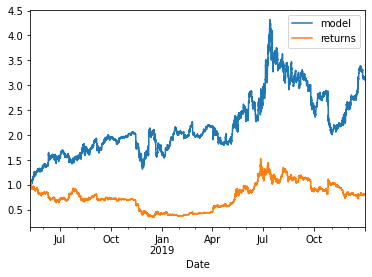

In [16]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=int(len(data.columns) * 0.2))
ftrs_sel = selector.fit(train_[cols], train['direction']).get_support(indices=True)
fsel = train_[cols].columns[ftrs_sel].tolist()

model = xgb_cl.fit(train_[fsel], train['direction'])
y_pred = model.predict(test_[fsel])
accuracy_score(test['direction'], y_pred)

# backtest
test['signals'] = np.where(y_pred == 1, 1, -1)
test['model'] = test['signals'] * test['returns']
test[['model', 'returns']].cumsum().apply(np.exp).plot()
test[['model', 'returns']].sum().apply(np.exp) -1

In [11]:
accuracy_score(test['direction'], y_pred)

0.5411177367910137

In [ ]:
# test['signals'] = np.where(y_pred == 1, 1, -1)
# test['model'] = test['signals'] * test['returns']
# test[['model', 'returns']].cumsum().apply(np.exp).plot()
# test[['model', 'returns']].sum().apply(np.exp) -1